# [Dataset](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)

# **Genre Prediction**


# Frame The Problem And Look At The Big Picture

1. ***Define the objective in business terms***:

- The goal of this project is to build a system that can classify music genres based on audio features extracted from songs. For this, we’re using the GTZAN dataset, which contains tracks labeled across 10 genres, such as Blues, Jazz, Rock, and Classical. The project involves analyzing the dataset to uncover patterns in the audio features that can help distinguish one genre from another. This work has practical applications in many areas. For example, music streaming platforms could use a system like this to improve their recommendation algorithms by better understanding the genres of songs. It could also help organize large music libraries by automatically tagging tracks with the correct genre, saving time and reducing human errors. Beyond that, it could provide insights into genre trends, which could be useful for the music industry in understanding listener preferences and market dynamics. Our ultimate goal is to develop a system that is both accurate and insightful, demonstrating the potential of audio-based classification for real-world use cases. Along the way, we’ll focus on understanding how audio features correlate with genre characteristics and how to improve the system’s accuracy through experimentation and optimization.

2. ***How will your solution be used***:
- Music streaming platforms could integrate it into their recommendation systems
- Music libraries could use it for automated genre tagging
- Music industry analysts could use it to study genre trends and market dynamics
- Could be used in real-time (for live genre classification) or batch processing (for library organization)

3. ***Current solutions/workarounds***:
- Manual genre tagging by music experts
- Existing audio classification like https://www.submithub.com/whats-my-genre

4. ***Problem framing***:
- This is a supervised learning problem as we have labeled data (songs with known genres)
- It's a multi-class classification task (10 different genres)
- Can be implemented as either online (real-time) or offline (batch) depending on the use case
- The GTZAN dataset provides labeled training data

5. ***Performance measurement***:
- Classification metrics like accuracy, precision, recall, and F1-score
- Confusion matrix to understand misclassifications between genres
- Below shows we're using `recall_macro` as the scoring metric for GridSearchCV
- `recall_macro` is a scoring metric used to evaluate the performance of a multi-class classification model. It calculates the recall for each class separately and then computes the unweighted (arithmetic) average of those recall values across all classes.
- Cross-validation scores to ensure robust performance

6. ***Minimum performance needed***:
- Highest accuracy possible, As many songs should be assigned their correct label as possible.
- Prioritizing: Recall

7. ***Comparable problems***:
- Speech recognition
- Sound classification
- Audio fingerprinting
- Music mood classification
- Artist identification from audio  
These all use similar audio feature extraction and classification techniques

8. ***Human expertise availability***:
- Music experts can manually classify genres
- Domain knowledge about audio features and their relationship to genres is available (as shown in the feature descriptions)

9. ***Manual solution process***:  
A human would:
- Listen to the audio
- Identify key characteristics like:
  - Instruments used
  - Rhythm patterns
  - Tempo
  - Vocal style
  - Harmonic structure
- Compare these characteristics against known genre conventions
- Make a classification based on overall similarity to genre patterns

10. ***Assumptions made***:
- The 10 genres in GTZAN dataset are sufficient to represent music diversity
- 30-second segments are enough to determine genre
- The dataset is representative of real-world music
- The genre labels in the training data are accurate

These assumptions could be verified by:
- Validating genre labels with multiple music experts
- Testing the model on more recent music releases

# **Get The Data**

#### Imports:

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

#### Loading the data:

In [3]:
# Function to load the dataset
def load_dataset(dataset_name=None):
    return pd.read_csv(f'data/{dataset_name}')

In [4]:
sec_data = load_dataset('features_3_sec.csv')
data = load_dataset('features_30_sec.csv')

### Found Jazz #54 is corrupted

In [5]:
import os
import pandas as pd
import librosa
import numpy as np
import soundfile as sf

def extract_features(y, sr):
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr).mean()
    chroma_stft_var = librosa.feature.chroma_stft(y=y, sr=sr).var()
    rms = librosa.feature.rms(y=y).mean()
    rms_var = librosa.feature.rms(y=y).var()
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    spectral_centroid_var = librosa.feature.spectral_centroid(y=y, sr=sr).var()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    spectral_bandwidth_var = librosa.feature.spectral_bandwidth(y=y, sr=sr).var()
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()
    rolloff_var = librosa.feature.spectral_rolloff(y=y, sr=sr).var()
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y).mean()
    zero_crossing_rate_var = librosa.feature.zero_crossing_rate(y=y).var()
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfcc_means = mfcc.mean(axis=1)
    mfcc_vars = mfcc.var(axis=1)
    return [
        chroma_stft, chroma_stft_var, rms, rms_var,
        spectral_centroid, spectral_centroid_var,
        spectral_bandwidth, spectral_bandwidth_var,
        rolloff, rolloff_var, zero_crossing_rate, zero_crossing_rate_var,
        *mfcc_means, *mfcc_vars
    ]

def split_and_process(file, output_dir, label, segment_duration=3):
    y, sr = librosa.load(file, sr=None)
    samples_per_segment = int(segment_duration * sr)
    for i, start_sample in enumerate(range(0, len(y), samples_per_segment)):
        end_sample = start_sample + samples_per_segment
        segment = y[start_sample:end_sample]
        
        if len(segment) < samples_per_segment:
            break
        
        output_filename = f"{os.path.splitext(os.path.basename(file))[0]}.{i}.wav"
        output_path = os.path.join(output_dir, output_filename)
        sf.write(output_path, segment, sr)

for file_name in data['filename']:
    input_file = f"./audio/{file_name.split('.')[0]}/{file_name}"
    output_directory = f"./audio/3_second/{file_name.split('.')[0]}"
    os.makedirs(output_directory, exist_ok=True)
    label = file_name.split('.')[0]
    try:
        split_and_process(input_file, output_directory, label)
    except Exception as e:
        print(f"Exception processing {input_file}: {e}")
    # print(f"Processed {input_file}")

/var/folders/gq/f3j82_650073w0x8z5ytw87w0000gp/T/ipykernel_19776/1599972703.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file, sr=None)
/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Exception processing ./audio/jazz/jazz.00054.wav: 


In [6]:
print(data.columns)


Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [7]:
"""
import soundfile as sf
# Creating audio files for the 5 second increments

for i in range(0, len(data)):
    if i == 0:
        start = 0
    else:
        start = data.iloc[i-1]['end']
    end = data.iloc[i]['end']
    audio, sr = sf.read(f'data/UrbanSound8K/audio/fold{data.iloc[i]["fold"]}/{data.iloc[i]["slice_file_name"]}')
    sf.write(f'data/5_sec_audio/{data.iloc[i]["slice_file_name"]}', audio[int(start*sr):int(end*sr)], sr)

"""

'\nimport soundfile as sf\n# Creating audio files for the 5 second increments\n\nfor i in range(0, len(data)):\n    if i == 0:\n        start = 0\n    else:\n        start = data.iloc[i-1][\'end\']\n    end = data.iloc[i][\'end\']\n    audio, sr = sf.read(f\'data/UrbanSound8K/audio/fold{data.iloc[i]["fold"]}/{data.iloc[i]["slice_file_name"]}\')\n    sf.write(f\'data/5_sec_audio/{data.iloc[i]["slice_file_name"]}\', audio[int(start*sr):int(end*sr)], sr)\n\n'

In [8]:
sec_data.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]


#### *Data Overview*

- The dataset contains 2 sets of audio features including spectral measurements, MFCCs, and temporal characteristics with no missing values.
- One dataset containing 30 second samples and the corresponding values and the other 3 second samples, both have the same features
- The dataset contains 1000 30 second songs with 100 songs for each of the 10 genres in a `.wav` format.
- The dataset also contains a Mel Spectrogram corresponding to each of the songs.

| Feature | Description |
|---------|------------|
| chroma_stft | Represents pitch content by mapping spectral data into 12 pitch classes |
| rms | Root Mean Square energy - represents the loudness/volume of the audio |
| spectral_centroid | Indicates where the "center of mass" of the sound is - relates to sound brightness |
| spectral_bandwidth | Width of the spectrum - indicates the range of frequencies |
| rolloff | Frequency below which most of the signal's energy is contained |
| zero_crossing_rate | Rate at which the signal changes from positive to negative - relates to noisiness |
| harmony | Measure of harmonic content vs noise in the signal |
| perceptr | Perceptual features of the sound |
| tempo | Speed/pace of the music in beats per minute |
| mfcc1-20 | Mel-frequency cepstral coefficients - represent the overall shape of the spectral envelope |

Note: Each feature has both _mean and _var (variance) measurements, representing the average value and how much it varies throughout the audio sample.


- 1,000 entries with 60 columns
- All data fields are completely populated
- Data types:
  - float64: 57 columns (audio features)
  - int64: 1 column (length)
  - object: 2 columns (filename, label)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

In [10]:
data.describe()

length  chroma_stft_mean  chroma_stft_var     rms_mean  \
count    1000.000000       1000.000000      1000.000000  1000.000000   
mean   662030.846000          0.378682         0.086340     0.130930   
std      1784.073992          0.081705         0.007735     0.065683   
min    660000.000000          0.171939         0.044555     0.005276   
25%    661504.000000          0.319562         0.082298     0.086657   
50%    661794.000000          0.383148         0.086615     0.122443   
75%    661794.000000          0.435942         0.091256     0.175682   
max    675808.000000          0.663685         0.108111     0.397973   

           rms_var  spectral_centroid_mean  spectral_centroid_var  \
count  1000.000000             1000.000000           1.000000e+03   
mean      0.003051             2201.780898           4.696916e+05   
std       0.003634              715.960600           4.008995e+05   
min       0.000004              570.040355           7.911251e+03   
25%       0.000942             1627.697311           1.843505e+05   
50%       0.001816             2209.263090           3.384862e+05   
75%       0.003577             2691.294667           6.121479e+05   
max       0.027679             4435.243901           3.036843e+06   

       spectral_bandwidth_mean  spectral_bandwidth_var  rolloff_mean  ...  \
count              1000.000000             1000.000000   1000.000000  ...   
mean               2242.541070           137079.155165   4571.549304  ...   
std                 526.316473            96455.666326   1574.791602  ...   
min                 898.066208            10787.185064    749.140636  ...   
25%                1907.240605            67376.554428   3380.069642  ...   
50%                2221.392843           111977.548036   4658.524473  ...   
75%                2578.469836           182371.576801   5533.810460  ...   
max                3509.646417           694784.811549   8677.672688  ...   

       mfcc16_mean   mfcc16_var  mfcc17_mean   mfcc17_var  mfcc18_mean  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      1.148144    60.730958    -3.966028    62.633624     0.507696   
std       4.578948    33.781951     4.549697    33.479172     3.869105   
min     -15.693844     9.169314   -17.234728    13.931521   -11.963694   
25%      -1.863280    40.376442    -7.207225    40.830875    -2.007015   
50%       1.212809    52.325077    -4.065605    54.717674     0.669643   
75%       4.359662    71.691755    -0.838737    75.040838     3.119212   
max      13.457150   392.932373    11.482946   406.058868    15.388390   

        mfcc18_var  mfcc19_mean   mfcc19_var  mfcc20_mean   mfcc20_var  
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  
mean     63.712586    -2.328761    66.231930    -1.095348    70.126096  
std      34.401977     3.755957    37.174631     3.837007    45.228512  
min      15.420555   -18.501955    13.487622   -19.929634     7.956583  
25%      41.884240    -4.662925    41.710184    -3.368996    42.372865  
50%      54.804890    -2.393862    57.423059    -1.166289    59.186117  
75%      75.385832     0.150573    78.626444     1.312615    85.375374  
max     332.905426    14.694924   393.161987    15.369627   506.065155  

[8 rows x 58 columns]

### *Data Histograms*

- Looking at these histograms, most of the audio features (like pitch, volume, and frequency measurements) follow bell-shaped distributions centered around specific values, while the variance features (showing how much these measurements change) tend to have right-skewed distributions with long tails, meaning most songs have small variations but some have very large changes in their audio characteristics.

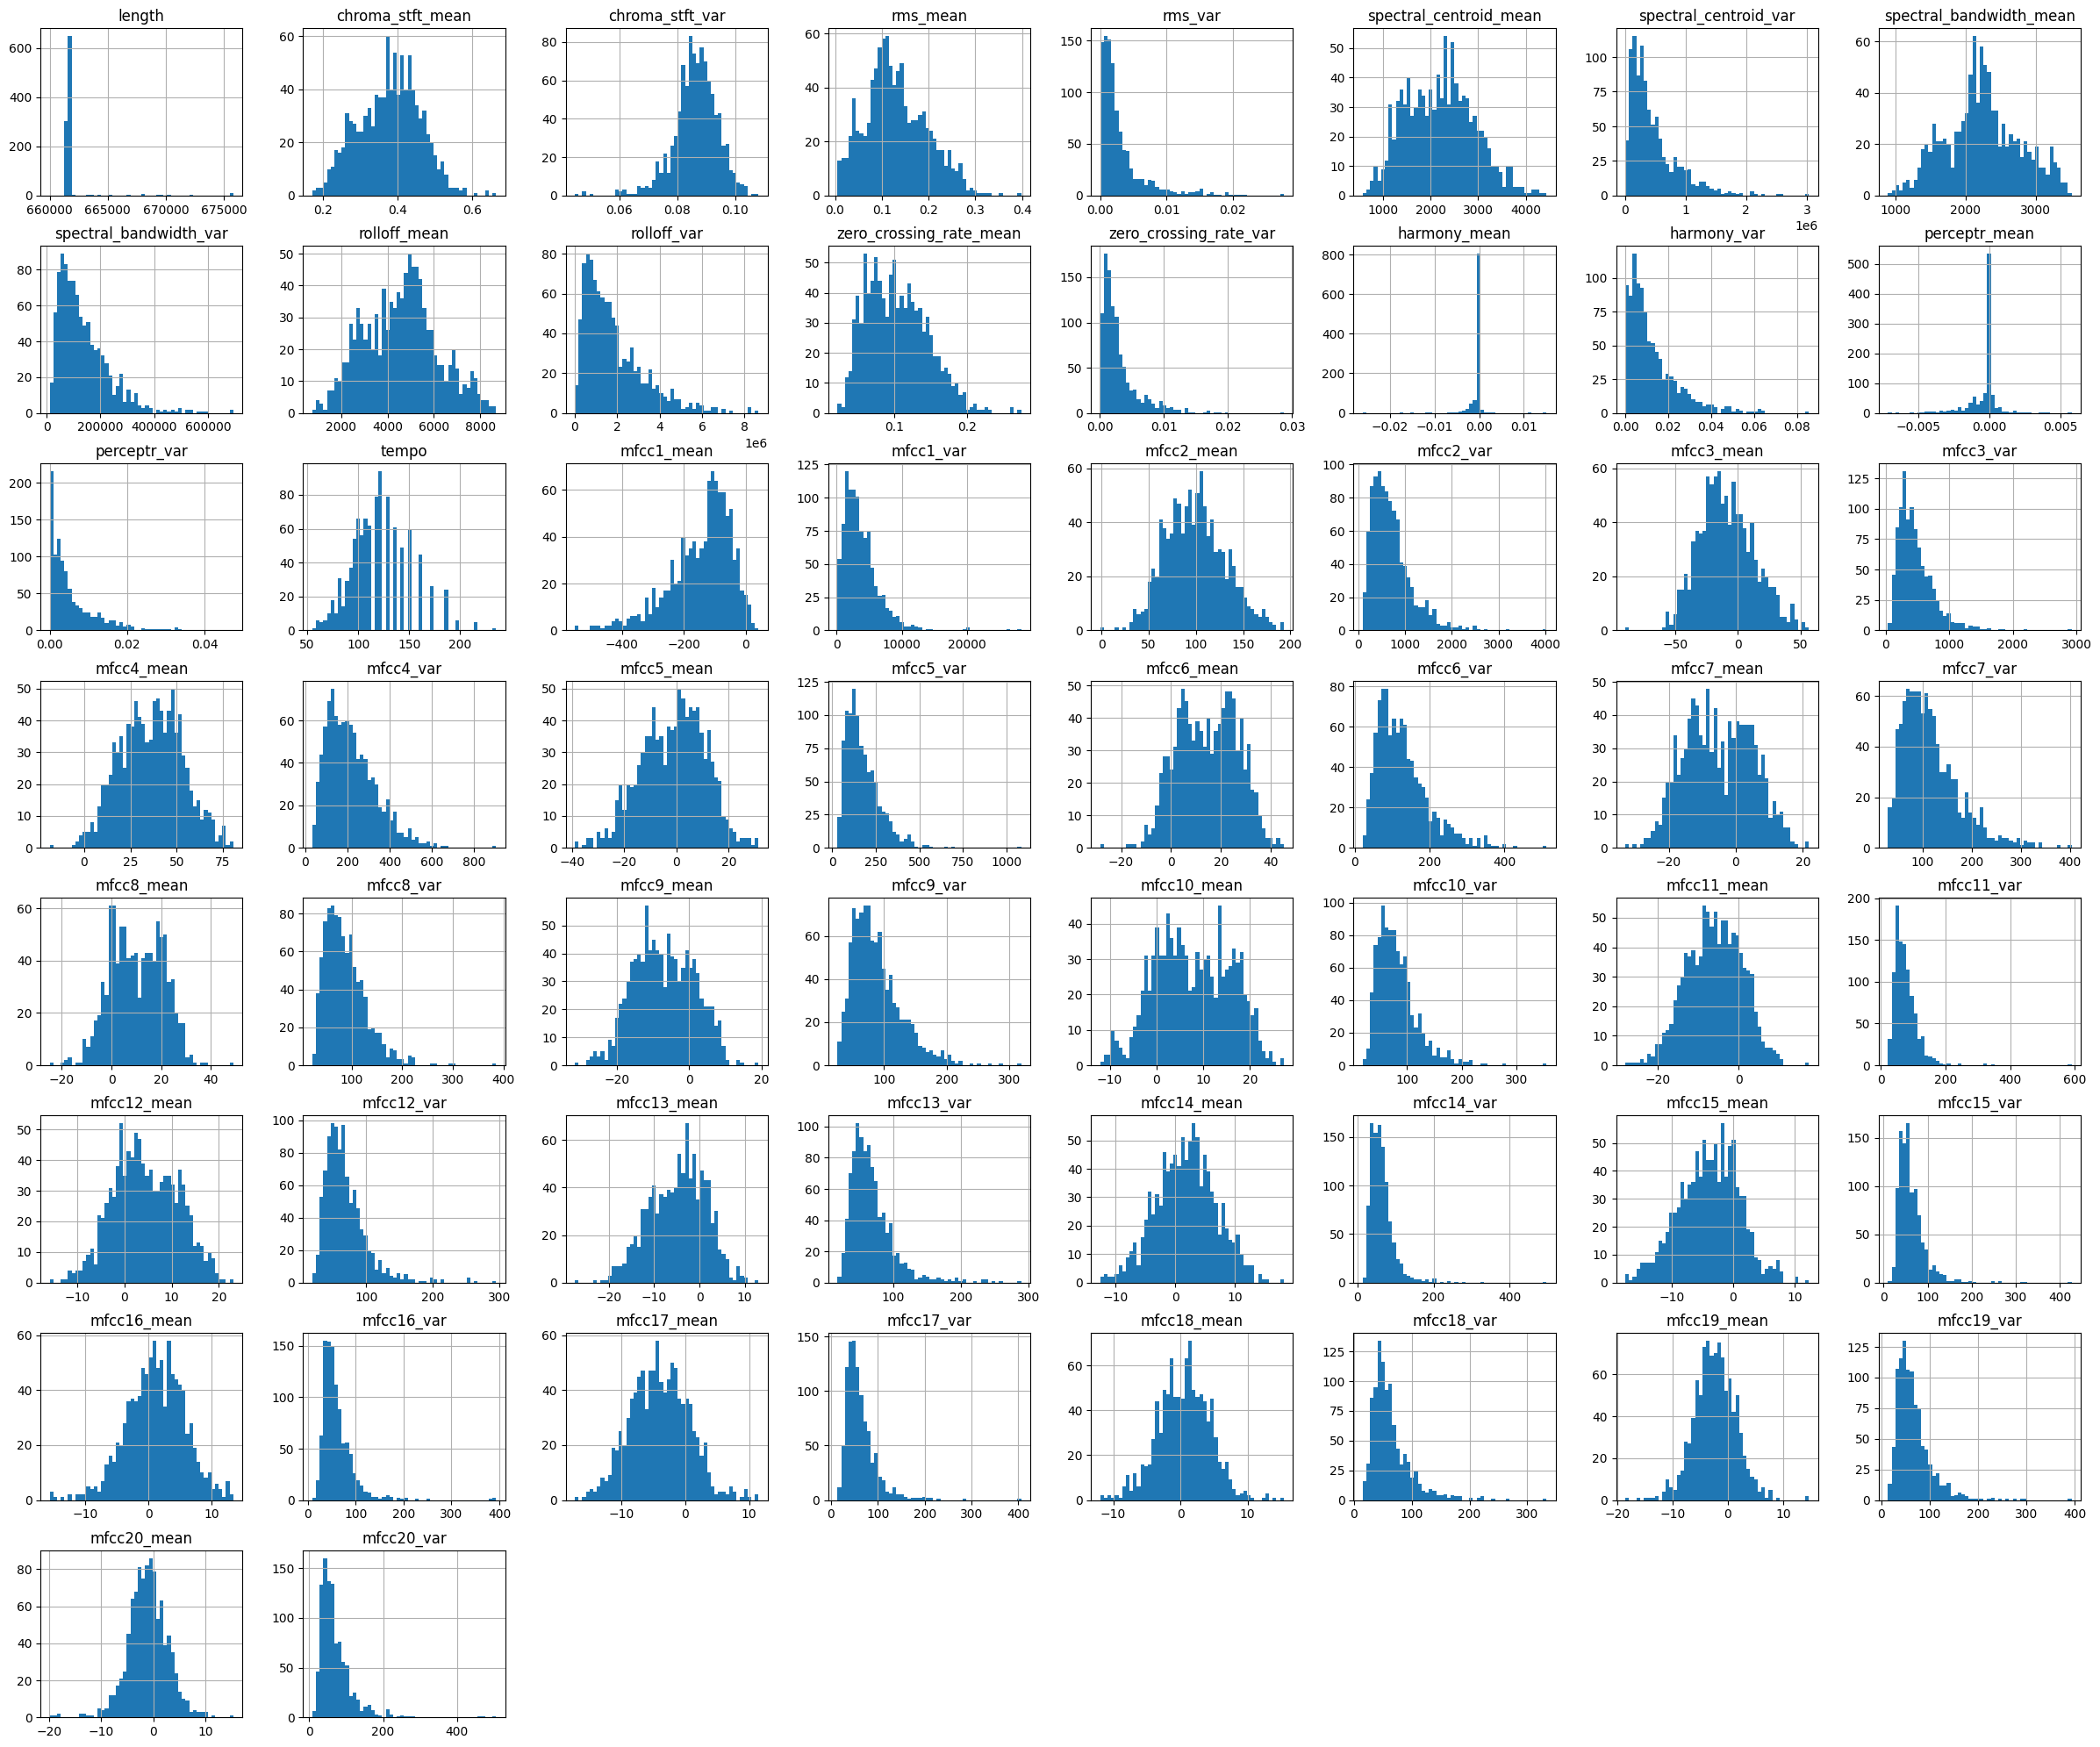

In [11]:
data.hist(bins=50, figsize=(30,25));

### *Splitting The Data Into Two Subsets*

-  The `train_set` containing 80% of the data for training and `test_set` containing 20% for testing, with the split being reproducible due to the specified `random_state`.

In [12]:
# Split the data into train and test sets
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])
data = train

# **Discover & Visualize the Data to Gain Insights**

### *Correlation Matrix Of Numerical Features* 
- This correlation matrix might look a bit tricky, but you can spot some patterns between audio features and MFCCs. In the upper left section, you’ll notice some moderate relationships between spectral and temporal audio features.

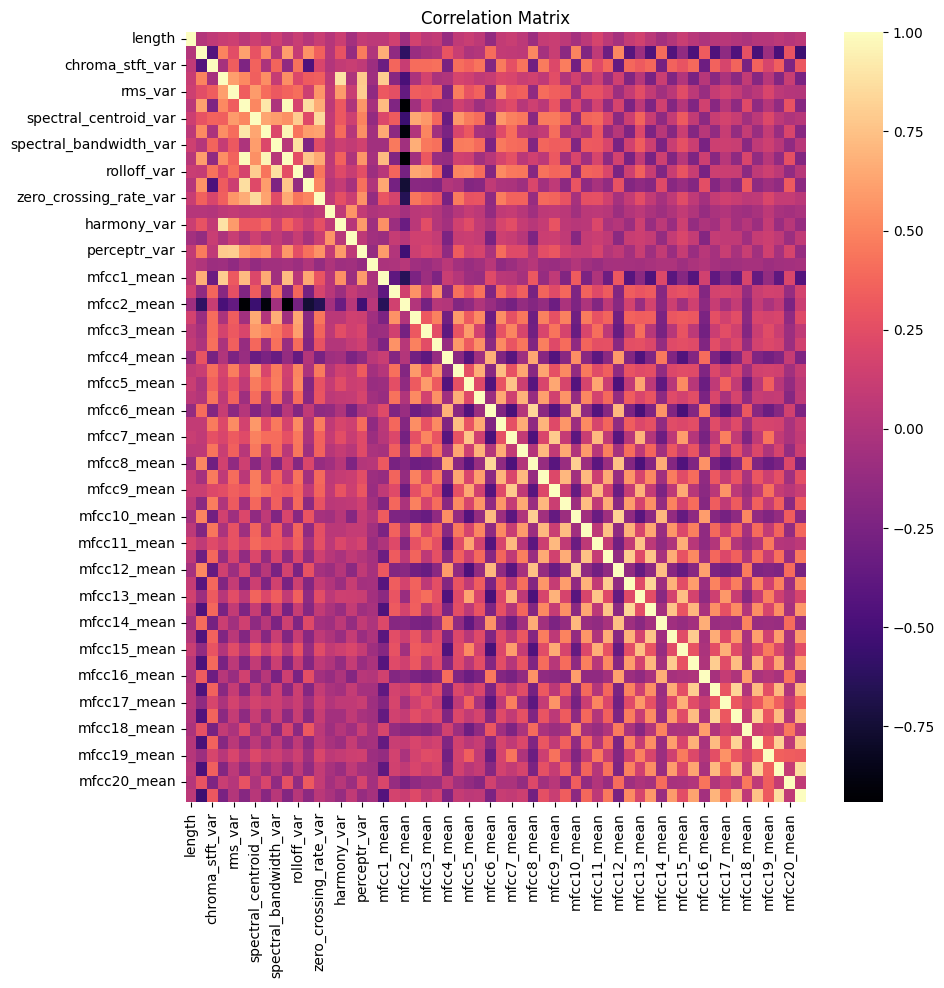

In [13]:
numeric_columns = data.select_dtypes(include=[np.number])

# Corelation matrix with sns
corr = numeric_columns.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=False, cmap='magma')
plt.title('Correlation Matrix')
plt.show()

### **RMS Feature Distributions Across Music Genres**

- The plot shows the distribution of the Root Mean Square (RMS) feature for different music genres, visualized using Kernel Density Estimation (KDE). It highlights how each genre's energy profile (loudness) varies, with genres like hip-hop and rock having distinct RMS characteristics compared to classical or jazz, which show more concentrated and narrower distributions.

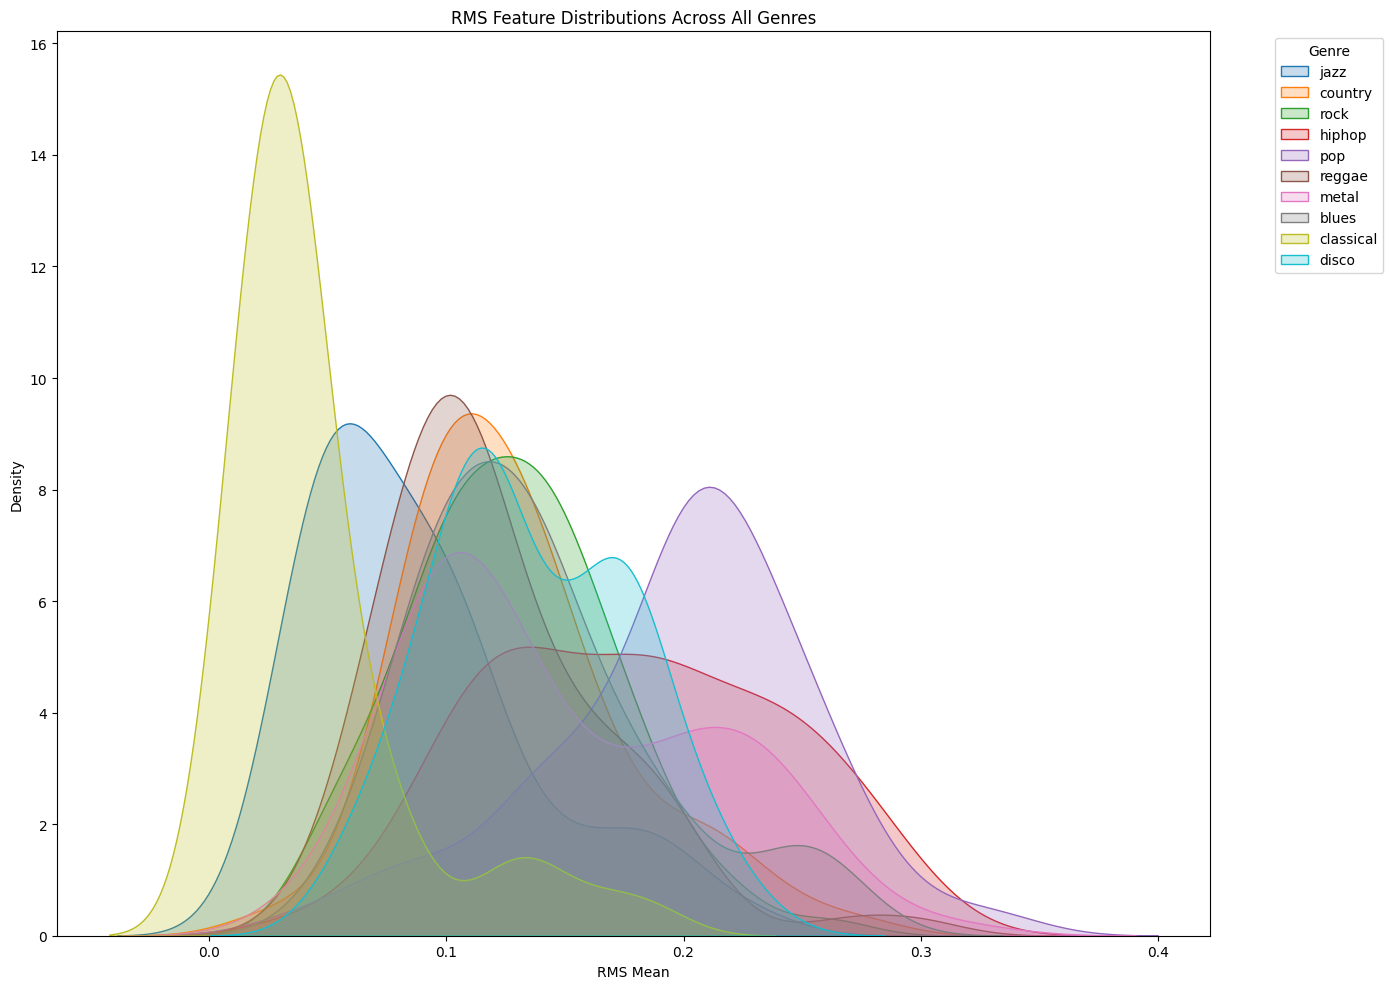

In [14]:
import warnings
plt.figure(figsize=(14, 10))

# Loop through all unique genres and plot their RMS feature distribution
warnings.filterwarnings('ignore')
for genre in data['label'].unique():
    sns.kdeplot(data=data[data['label'] == genre]['rms_mean'], label=genre, shade=True)

plt.title('RMS Feature Distributions Across All Genres')
plt.xlabel('RMS Mean')
plt.ylabel('Density')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

### *Spectral Centroid Across Genres*
- This chart compares the brightness or treble characteristics of different music genres using box plots, where higher values indicate brighter, more treble-heavy sounds, and lower values indicate darker, more bass-heavy sounds. Pop music shows the highest median brightness while classical and blues genres tend toward darker tones, and jazz displays the most variability in its tonal characteristics, ranging from very dark to very bright sounds.

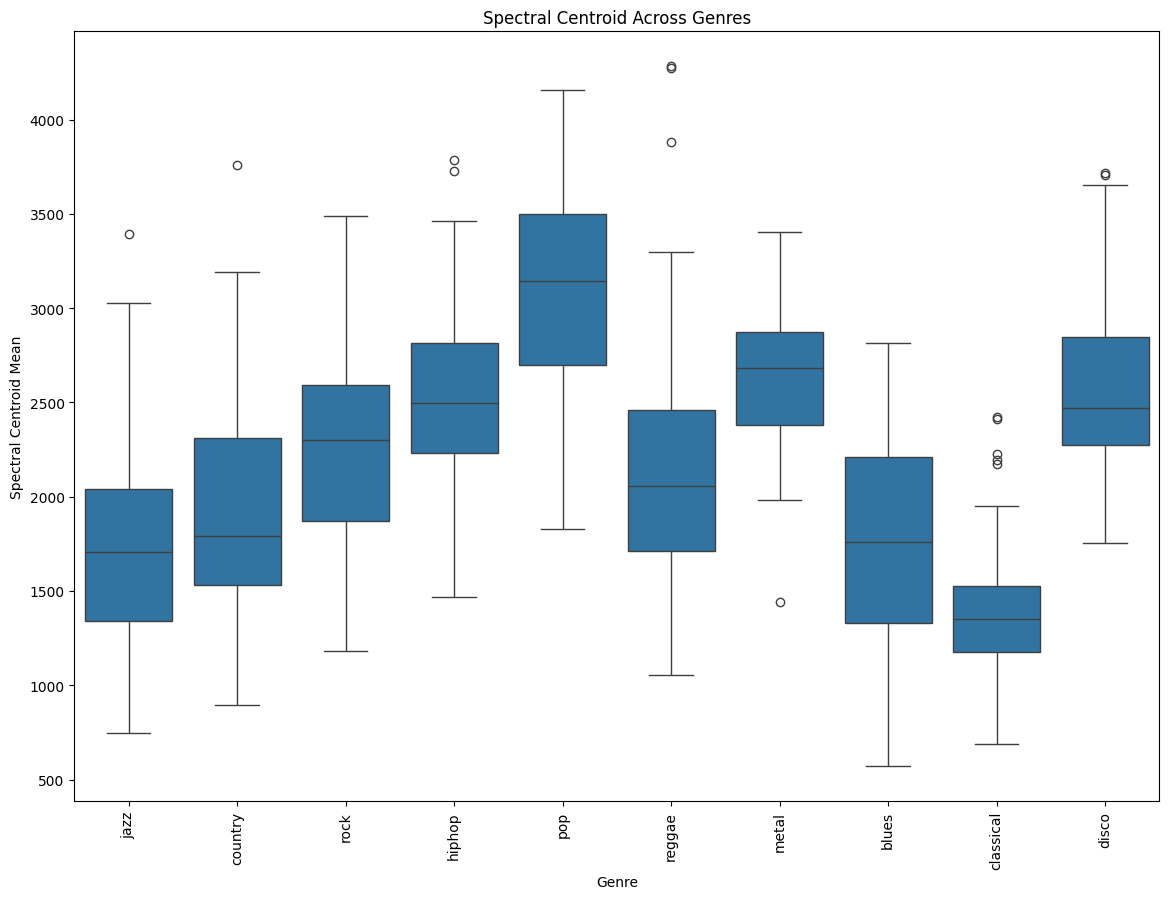

In [15]:
# Visualizing spectral_centroid across genres
plt.figure(figsize=(14, 10))
sns.boxplot(x='label', y='spectral_centroid_mean', data=data)
plt.title('Spectral Centroid Across Genres')
plt.xlabel('Genre')
plt.ylabel('Spectral Centroid Mean')
plt.xticks(rotation=90)
plt.show()



### *MFCC1 Mean Across Genres*

- This chart compares the first Mel-frequency cepstral coefficient (MFCC1) across different music genres, which reflects the overall energy distribution in the frequency spectrum. Classical music has the lowest median MFCC1 values and the most variability, indicating it has less consistent energy. Metal and pop, on the other hand, have higher median values, showing they have more consistent and energetic frequency content.

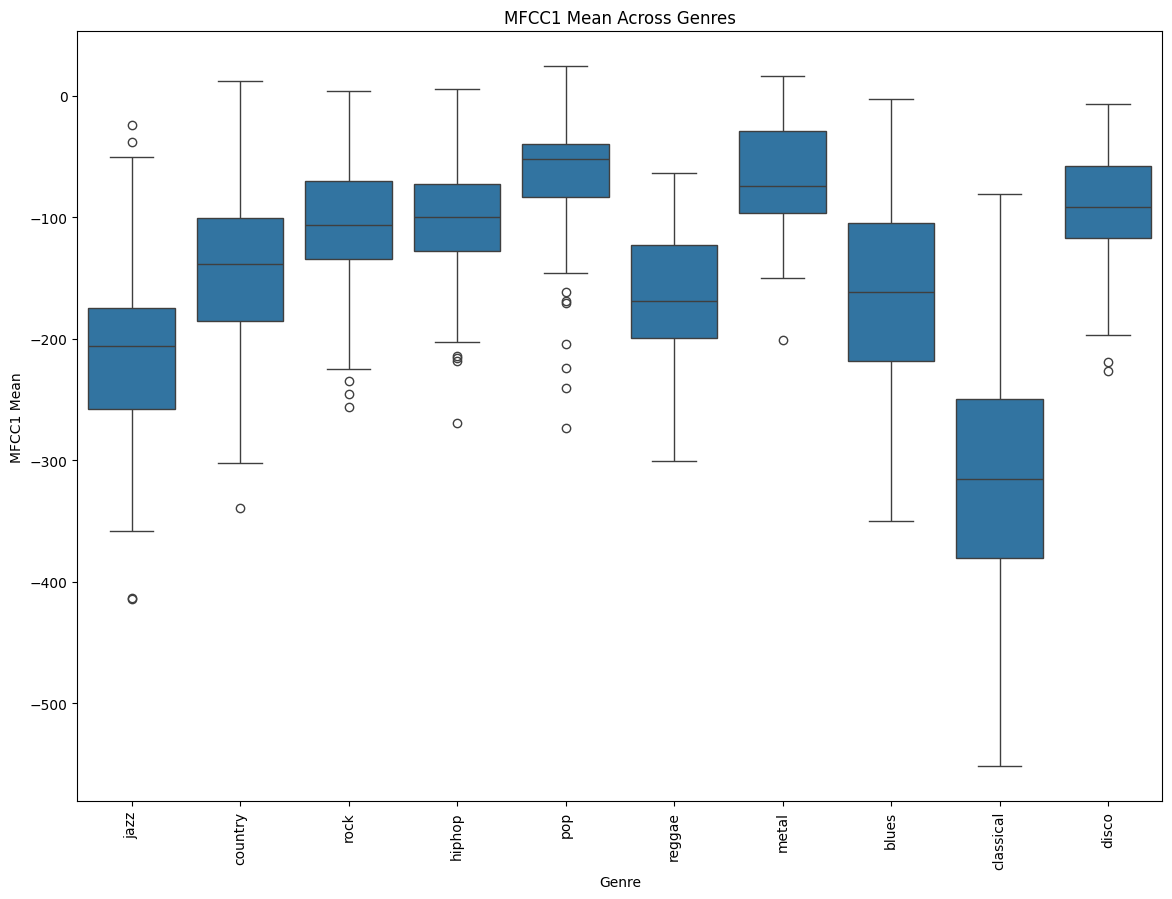

In [16]:
# Visualizing mfcc1_mean across genres
plt.figure(figsize=(14, 10))
sns.boxplot(x='label', y='mfcc1_mean', data=data)
plt.title('MFCC1 Mean Across Genres')
plt.xlabel('Genre')
plt.ylabel('MFCC1 Mean')
plt.xticks(rotation=90)
plt.show()

### *Using Librosa*

- **So we are going to use Librosa, which is a Python library for analyzing and processing audio signals, widely used in music information retrieval and machine learning applications.**

- This code uses **Librosa** to load an audio file, obtaining its time series (`y`) and sample rate (`sr`). It prints the shape of the audio array (`661504` samples), the sample rate (`22050 Hz`), and the audio length (`30 seconds`).










In [17]:
import librosa 
import librosa.display  
audio_path = "./audio/metal/metal.00094.wav"
# needs to be numpy 2.0 because librosa thinks its funny to break with numpy 1.21
%pip install numpy==2.0
# Load the audio file using librosa, y is the audio time series and sr is the sampling rate of y 
y, sr = librosa.load(audio_path)
y_shape = np.shape(y)  
print(f"y shape: {y_shape}, sample rate: {sr}, length: {y_shape[0] / sr} seconds")

You should consider upgrading via the '/Users/figueroaf/Desktop/Genre-Prediciton/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
y shape: (661504,), sample rate: 22050, length: 30.00018140589569 seconds


### Audio Waveform
- As you can see you can use librosa to create a visual representation of an audio waveform, or a audio signal as a waveplot, showing the changes in amplitude over time.



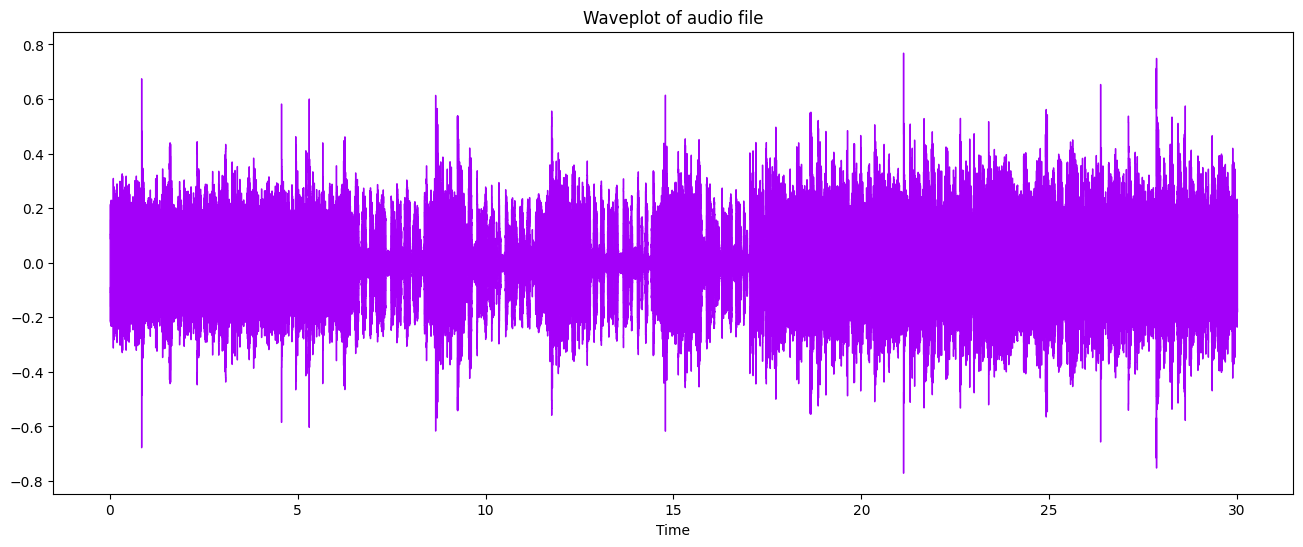

In [18]:
plt.figure(figsize=(16, 6)) 
librosa.display.waveshow(y, sr=sr, color="#A300F9") 
plt.title("Waveplot of audio file");

### *Audio STFT Spectogram*

- We can also use Librosa to create a spectrogram of an audio file, showing how its frequency content changes over time. It uses the Short-Time Fourier Transform (STFT) to convert the signal into a frequency domain and displays it in decibels on a logarithmic frequency scale.








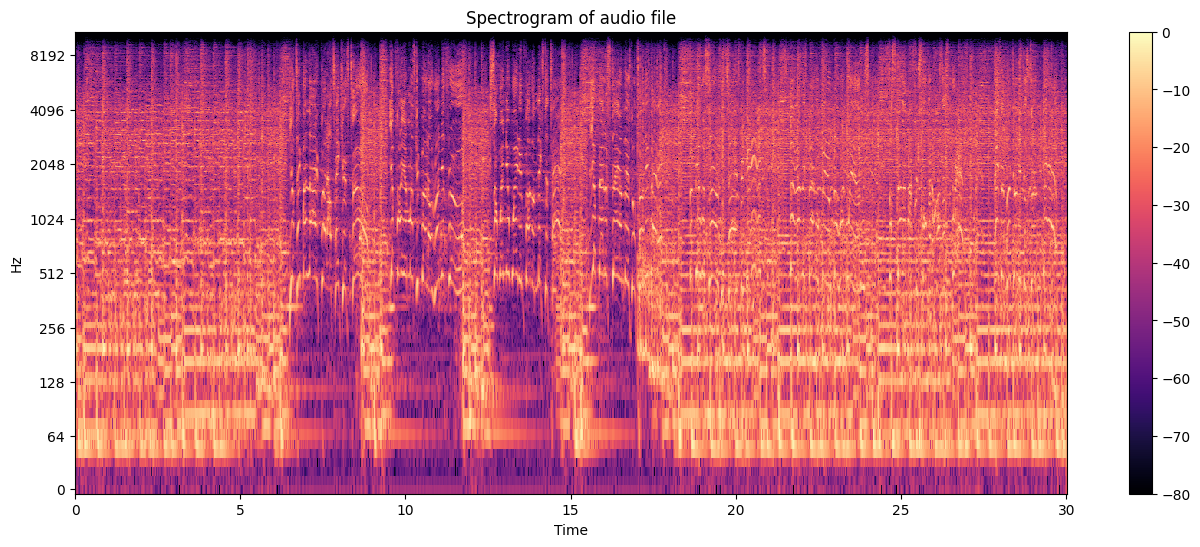

In [19]:
n_fft = 2048 
hop_length = 512  
audio_file, _ = librosa.effects.trim(y) 
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))  
DB = librosa.amplitude_to_db(D, ref = np.max)  
plt.figure(figsize = (16, 6)) 
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log') 
plt.colorbar();
plt.title("Spectrogram of audio file");
plt.show()

### *Average Energy (RMS) by Genre*

- This bar graph shows the average RMS (Root Mean Square) energy for different music genres. The pop genre has the highest energy, while classical has the lowest. By the way the  RMS (Root Mean Square) energy is basicaly the loudness of an audio signal by calculating the square root of the average of the squared values of the signal's waveform

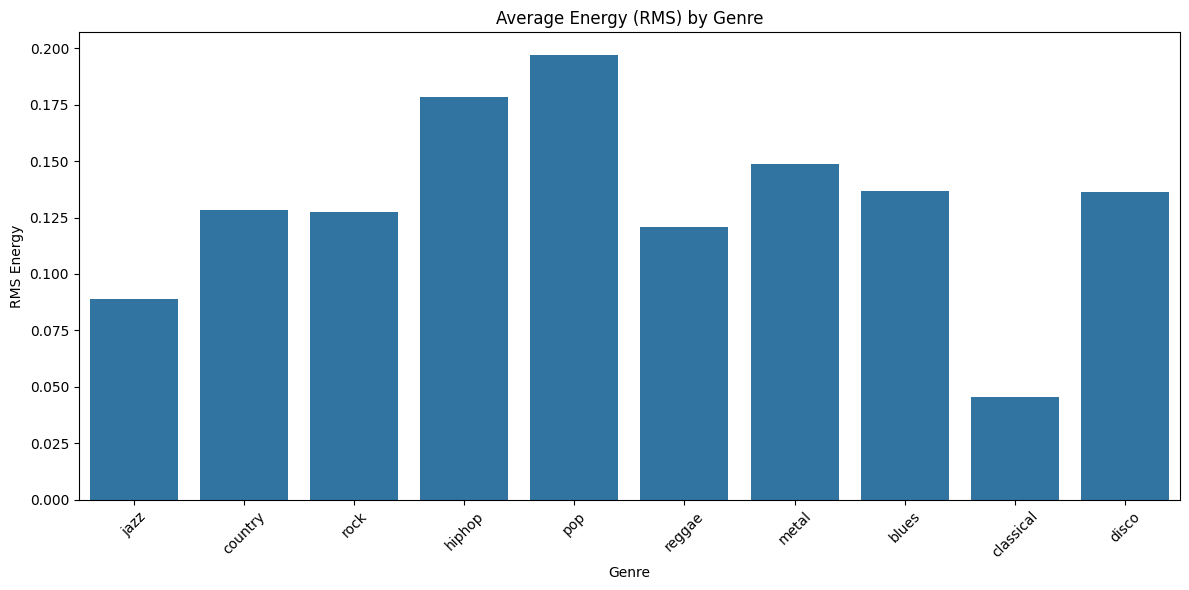

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='label', y='rms_mean', ci=None)
plt.title('Average Energy (RMS) by Genre')
plt.xlabel('Genre')
plt.ylabel('RMS Energy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Audio Mel Spectrogram

- This is similar to the other spectogram, its better for analyzing audio because it mimics how humans hear sound. It compresses the frequency axis to focus on the frequencies we are most sensitive to, making it more efficient for tasks like speech or music recognition (which is our case).

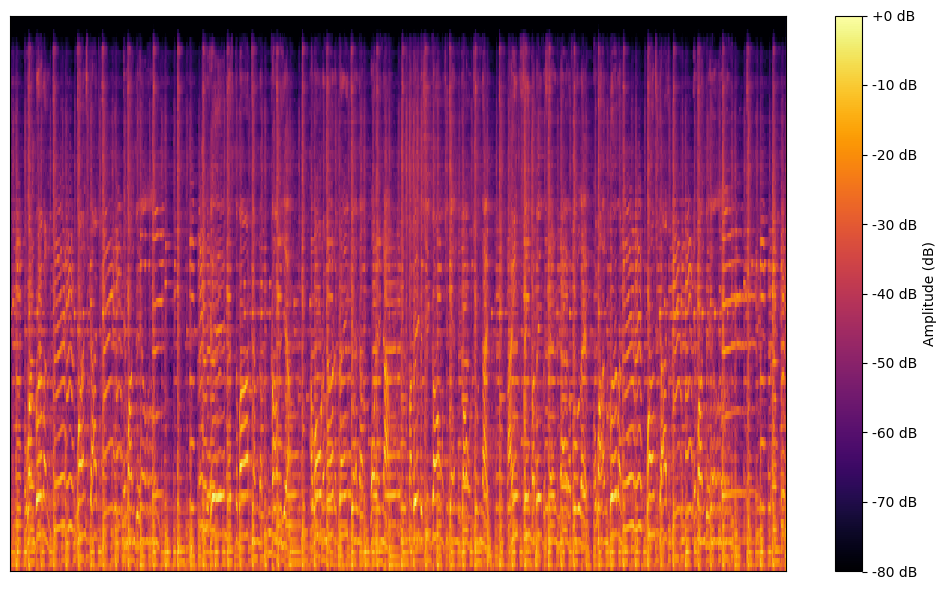

In [21]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

file = "./audio/blues/blues.00000.wav"  # Correct path
y, sr = librosa.load(file, sr=None)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spec_db, sr=sr, cmap='inferno')
plt.colorbar(format='%+2.0f dB', label="Amplitude (dB)")
plt.tight_layout()
plt.show()

# **Prepare The Data For Machine Learning Algorithms**
### *Model Imports*

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV


### *Predicting Label for X and Y*


In [23]:
# predict label give X and y val for both train and test

X = train.drop(columns=['label'])
y = train['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

### *Customer Transformers*

1. **ExtractMelSpectogram**: This class loads an audio file, detects its tempo, but doesn't return the Mel spectrogram yet (unfinished).

2. **LoadMelSpectograms**: This class loads audio files, computes their Mel spectrograms, and adds them as a new column in the dataset.

In [24]:
# Transformers
from sklearn.base import BaseEstimator, TransformerMixin

class ExtractMelSpectogram(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        split_file_path = X['filename'].split('.')
        audio_path = f"./audio/{split_file_path[0]}/{X['filename']}"
        y, sr = librosa.load(audio_path)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        return
    
class LoadMelSpectograms(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        mel_specs = [] 
        for i in range(X.shape[0]):
            split_file_path = X['filename'].iloc[i].split('.')
            audio_path = f"./audio/{split_file_path[0]}/{X['filename'].iloc[i]}"
            y, sr = librosa.load(audio_path)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_specs.append(mel_spec)
            X["mel_spec"] = mel_specs
        return X

### Audio Preprocessing Pipeline Explanation

This code creates a pipeline that prepares audio data for machine learning in 3 main steps:

1. **Audio Feature Extractor**
   - Simply removes the filename column 
   - Keeps all the numerical data about the audio features

2. **Additional Features Creator**
   - Creates new useful features by combining existing ones
   - For example: combines pitch and volume features to create new ratios
   - Also calculates average and variation of certain audio properties (MFCCs)

3. **Feature Scaler**
   - Groups similar features together (base features, MFCCs, variance features)
   - Scales each group separately to make sure all numbers are in a similar range
   - This helps the machine learning model perform better

Think of it like a recipe:
1. First, remove ingredients we don't need (filenames)
2. Then create new ingredients by mixing existing ones
3. Finally, measure everything in the same units so they work well together



### *Pipeline for Extracting and Processing Mel Spectrogram Features from Existing and Generated Audio*


The code provides two pipelines for processing audio data: 

1. **ExistingSpectrogramProcessor**: This pipeline can be used when you already have a dataset with extracted features, such as MFCCs and spectral features, and you want to filter and standardize these features for machine learning tasks like genre classification. For example, you can input a dataset with columns like `mfcc_1_mean`, `spectral_centroid_mean`, and it will output these cleaned and standardized features ready for model training.

2. **GeneratedSpectrogramProcessor**: This pipeline is used to generate features from raw audio files, such as calculating mel spectrograms, MFCCs, and spectral centroids from songs. For example, given a folder of `.wav` files, this pipeline will process each file to extract features like `mel_mean`, `mfcc_1_mean`, and `spec_centroid_mean`, which can be used in machine learning models for tasks like genre classification or music recommendation.




In [25]:
import numpy as np
import librosa
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

class ExistingSpectrogramProcessor(BaseEstimator, TransformerMixin):
    """Process existing mel spectrograms from the dataset"""
    def __init__(self):
        self.feature_names = []
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        # Filter out the corrupted file if present
        X = X[X['filename'] != 'jazz.00054.wav'].copy()
        
        # Extract only the mel spectrogram related features from existing data
        mel_features = [col for col in X.columns if 'mfcc' in col]
        spectral_features = [col for col in X.columns if 'spectral' in col]
        self.feature_names = mel_features + spectral_features
        
        return X[self.feature_names]

class GeneratedSpectrogramProcessor(BaseEstimator, TransformerMixin):
    """Generate and process new mel spectrograms from audio files"""
    def __init__(self, n_mels=128, hop_length=512, n_mfcc=20):
        self.n_mels = n_mels
        self.hop_length = hop_length
        self.n_mfcc = n_mfcc
        self.feature_template = None
        
    def fit(self, X, y=None):
        return self
        
    def _process_audio_file(self, audio_path):
        """Process a single audio file and extract features"""
        y, sr = librosa.load(audio_path, sr=None)
        
        # Generate mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=y, 
            sr=sr, 
            n_mels=self.n_mels,
            hop_length=self.hop_length
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        features = {}
        
        # Calculate statistical features
        features['mel_mean'] = np.mean(mel_spec_db)
        features['mel_std'] = np.std(mel_spec_db)
        features['mel_max'] = np.max(mel_spec_db)
        features['mel_min'] = np.min(mel_spec_db)
        
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)
        for i, mfcc in enumerate(mfccs):
            features[f'mfcc_{i+1}_mean'] = np.mean(mfcc)
            features[f'mfcc_{i+1}_std'] = np.std(mfcc)
        
        # Calculate spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        features['spec_centroid_mean'] = np.mean(spectral_centroid)
        features['spec_centroid_std'] = np.std(spectral_centroid)
        
        return features
        
    def transform(self, X):
        # Filter out the corrupted file
        X = X[X['filename'] != 'jazz.00054.wav'].copy()
        
        features_list = []
        valid_indices = []
        
        for idx, filename in enumerate(X['filename']):
            try:
                audio_path = f"./audio/{filename.split('.')[0]}/{filename}"
                if os.path.exists(audio_path):
                    features = self._process_audio_file(audio_path)
                    features_list.append(features)
                    valid_indices.append(idx)
            except Exception as e:
                print(f"Skipping {filename}: {str(e)}")
                continue
        
        if not features_list:
            raise ValueError("No valid audio files were processed")
        
        # Convert to numpy array
        feature_matrix = np.array([[v for v in d.values()] for d in features_list])
        
        return feature_matrix

def create_existing_spectrogram_pipeline():
    """Create pipeline for processing existing spectrograms"""
    return Pipeline([
        ('processor', ExistingSpectrogramProcessor()),
        ('scaler', StandardScaler())
    ])

def create_generated_spectrogram_pipeline():
    """Create pipeline for generating and processing new spectrograms"""
    return Pipeline([
        ('processor', GeneratedSpectrogramProcessor()),
        ('scaler', StandardScaler())
    ])

def process_data(X, y=None, pipeline_type='existing'):
    """
    Process data using specified pipeline type
    
    Args:
        X: Input data DataFrame
        y: Labels (optional)
        pipeline_type: 'existing' or 'generated'
    
    Returns:
        Processed features and filtered labels (if provided)
    """
    # Create a copy of the data to avoid modifying the original
    X = X.copy()
    
    # Remove the corrupted file from both X and y
    mask = X['filename'] != 'jazz.00054.wav'
    X = X[mask]
    
    if y is not None:
        y = y[mask]
    
    # Select appropriate pipeline based on type
    if pipeline_type == 'existing':
        pipeline = create_existing_spectrogram_pipeline()
    else:
        pipeline = create_generated_spectrogram_pipeline()
    
    # Process the data using the pipeline
    X_processed = pipeline.fit_transform(X)
    
    if y is not None:
        return X_processed, y
    return X_processed

# Final Preprocessor
def final_preprocessor(X, y=None, pipeline_type='existing'):
    """
    Complete preprocessing function that processes the input data and applies the appropriate pipeline.
    
    Args:
        X: Input data DataFrame
        y: Labels (optional)
        pipeline_type: 'existing' or 'generated'
    
    Returns:
        Processed features and labels (if provided)
    """
    return process_data(X, y, pipeline_type)

# The Preprocessor
preprocessor = final_preprocessor
preprocessor


<function __main__.final_preprocessor(X, y=None, pipeline_type='existing')>

### *Handling Audio Data with and without Labels Using Mel Spectrogram Processing Pipelines*

In [26]:
# If you don't have labels:
X_existing = process_data(data, pipeline_type='existing')
X_generated = process_data(data, pipeline_type='generated')

# If you have labels:
X_existing, y_filtered = process_data(data, y, pipeline_type='existing')
X_generated, y_filtered = process_data(data, y, pipeline_type='generated')

### *Accuracy For Model With Generated Vs Existing Data*

In [ ]:

def simple_compare_models(X_existing, X_generated, y_filtered):
    # Define models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'SVM': SVC(kernel='rbf', random_state=42)
    }
    
    # Store results
    results = {}
    
    for name, model in models.items():
        # Test existing features
        model.fit(X_existing, y_filtered)
        existing_score = model.score(X_existing, y_filtered) * 100
        
        # Test generated features
        model.fit(X_generated, y_filtered)
        generated_score = model.score(X_generated, y_filtered) * 100
        
        results[name] = {
            'Existing': f"{existing_score:.1f}%",
            'Generated': f"{generated_score:.1f}%"
        }
    
    # Print results in a simple format
    print("\nAccuracy Comparison:")
    print("-" * 50)
    print(f"{'Model':<20} {'Existing':<15} {'Generated':<15}")
    print("-" * 50)
    for model, scores in results.items():
        print(f"{model:<20} {scores['Existing']:<15} {scores['Generated']:<15}")

# Run comparison
simple_compare_models(X_existing, X_generated, y_filtered)

NameError: name 'SVC' is not defined

### Confusion Matrices For Generated Vs Extracted Data

- Looking at these confusion matrices, `Random Forest` and `Gradient Boosting` models perform exceptionally well with both existing and generated features, consistently achieving around 80 correct predictions for each class (shown by the dark diagonal values) with almost no misclassifications. In contrast, the `SVM` model performs notably worse, with more misclassifications (shown by the off-diagonal numbers) and lower accuracy scores around 60-70 for each class.

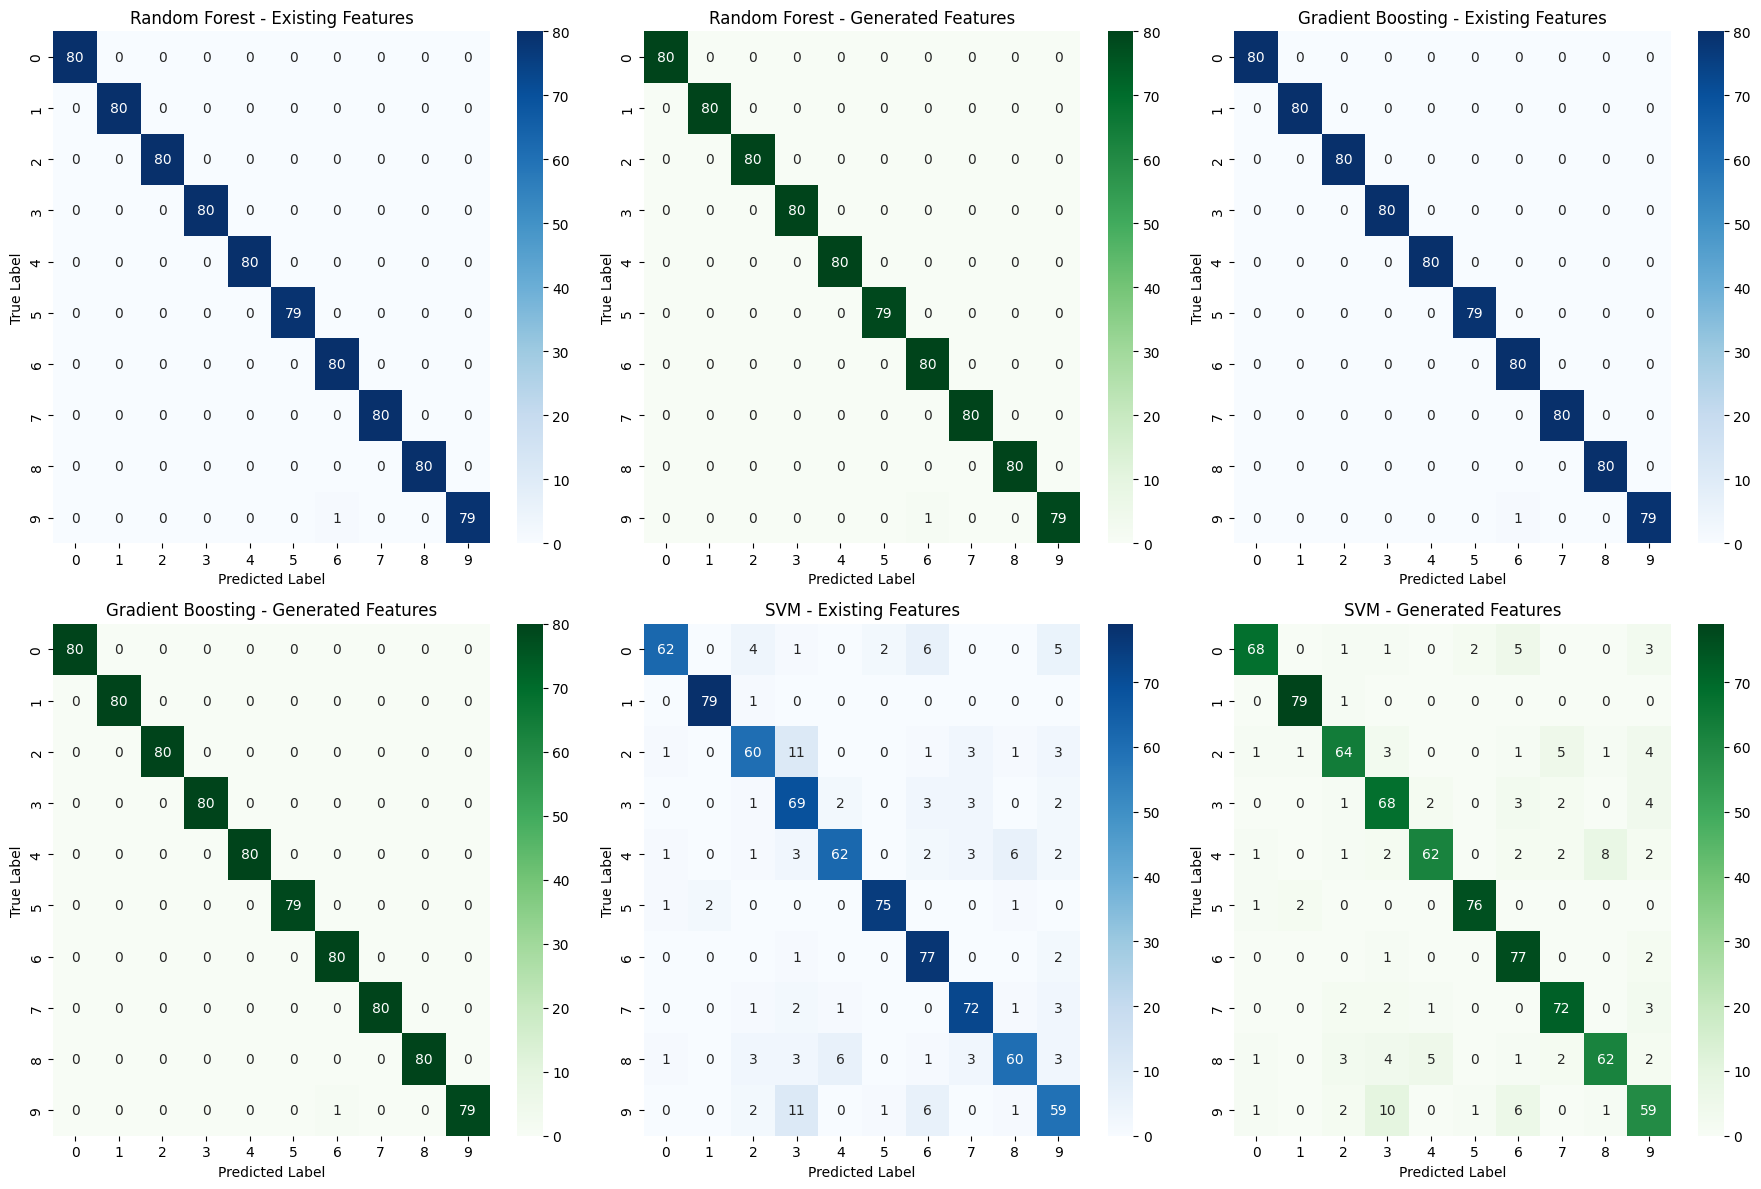

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrices(X_existing, X_generated, y_filtered):
    # Define models to test
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'SVM': SVC(kernel='rbf', random_state=42)
    }
    
    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()  # Flatten for easier indexing
    
    for i, (name, model) in enumerate(models.items()):
        # Train and evaluate on existing features
        model.fit(X_existing, y_filtered)
        existing_pred = model.predict(X_existing)
        existing_cm = confusion_matrix(y_filtered, existing_pred)
        
        # Train and evaluate on generated features
        model.fit(X_generated, y_filtered)
        generated_pred = model.predict(X_generated)
        generated_cm = confusion_matrix(y_filtered, generated_pred)
        
        # Plot confusion matrix for existing features
        sns.heatmap(existing_cm, annot=True, fmt='d', cmap='Blues', ax=axes[i * 2])
        axes[i * 2].set_title(f'{name} - Existing Features')
        axes[i * 2].set_ylabel('True Label')
        axes[i * 2].set_xlabel('Predicted Label')
        
        # Plot confusion matrix for generated features
        sns.heatmap(generated_cm, annot=True, fmt='d', cmap='Greens', ax=axes[i * 2 + 1])
        axes[i * 2 + 1].set_title(f'{name} - Generated Features')
        axes[i * 2 + 1].set_ylabel('True Label')
        axes[i * 2 + 1].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrices(X_existing, X_generated, y_filtered)

### *Existing Vs Generate Spectogram*

- Alright, so here's what we're looking at: on the left, we've got the **generated spectrogram**, and on the right are the **existing MFCC features**. The spectrogram shows way more detail over time, while the MFCCs are more simplified and smoothed out. Even though they’re **81.3% similar**, the spectrogram captures richer information, which means using it might give us better results than sticking with the existing features.

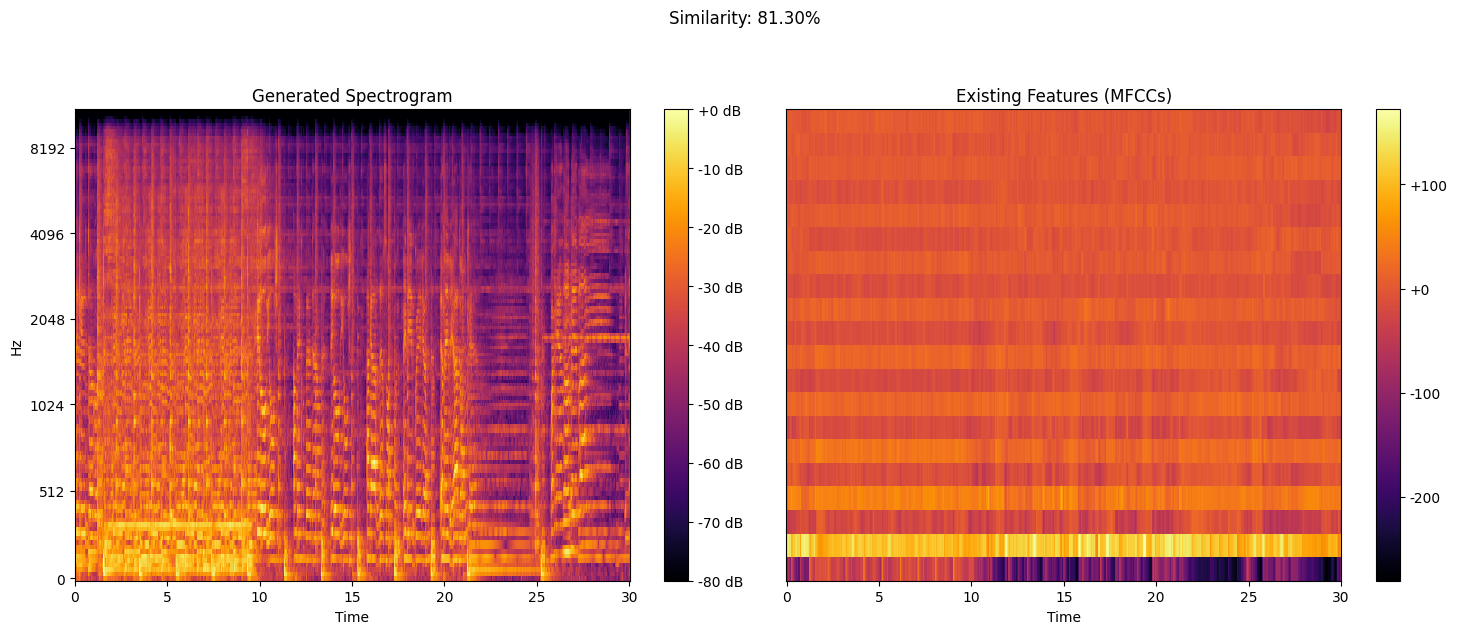

Similarity percentage: 81.30%


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom

def compare_spectrograms_with_similarity(audio_path):
    plt.figure(figsize=(15, 6))
    
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None)
    
    # 1. Generated Spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=y, 
        sr=sr, 
        n_mels=128,
        hop_length=512
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    plt.subplot(1, 2, 1)
    librosa.display.specshow(
        mel_spec_db, 
        sr=sr, 
        x_axis='time', 
        y_axis='mel',
        cmap='inferno'
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title('Generated Spectrogram')
    
    # 2. Existing Features (MFCCs)
    plt.subplot(1, 2, 2)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    
    librosa.display.specshow(
        mfccs, 
        sr=sr, 
        x_axis='time',
        cmap='inferno'
    )
    plt.colorbar(format='%+2.0f')
    plt.title('Existing Features (MFCCs)')
    
    # Calculate similarity
    mel_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
    mfcc_norm = (mfccs - mfccs.min()) / (mfccs.max() - mfccs.min())
    
    # Calculate zoom factors
    zoom_factors = (mel_norm.shape[0] / mfcc_norm.shape[0], 
                   mel_norm.shape[1] / mfcc_norm.shape[1])
    
    # Resize MFCC to match mel spectrogram size
    mfcc_resized = zoom(mfcc_norm, zoom_factors)
    
    # Calculate similarity (as percentage)
    similarity = 100 * (1 - np.mean(np.abs(mel_norm - mfcc_resized)))
    
    plt.suptitle(f'Similarity: {similarity:.2f}%', y=1.05)
    plt.tight_layout()
    plt.show()
    
    return similarity

# Example usage
audio_path = "./audio/rock/rock.00000.wav"  # Replace with your audio file
similarity = compare_spectrograms_with_similarity(audio_path)
print(f"Similarity percentage: {similarity:.2f}%")